In [4]:
import pandas as pd
import numpy as np
import math
import time
import scipy.optimize as opt
from scipy.optimize import minimize
import scipy.stats as stats
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [5]:
#first read the stata file (for data)
dt=pd.read_stata('PS3_data.dta')

#data
dt.describe()

,id68,year,intid,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,hrace,...,redpregovinc,hsex,wsex,age,wage,hpersno,wpersno,hyrsed,wyrsed,pce
count,123786.000000,123786.000000,123786.000000,123786.000000,123786.000000,9.023300e+04,48496.000000,123786.000000,90603.000000,123656.000000,...,1.237860e+05,123786.000000,80758.0,123786.000000,80758.000000,123786.000000,80758.000000,122809.000000,80091.000000,123786.000000
mean,1494.639475,1984.831273,3271.379429,1679.269897,633.026917,4.211505e+04,22026.289062,0.843771,1.098220,1.129731,...,3.012258e+04,1.233072,2.0,45.545547,41.390785,39.620201,55.346169,12.666091,12.720081,0.557690
std,838.901790,9.836212,2277.056058,1061.704712,878.422791,4.670424e+04,21336.107422,1.182829,0.356161,0.394627,...,4.588795e+04,0.422940,0.0,17.623671,14.786721,69.003265,77.864296,2.917721,2.422607,0.265198
min,1.000000,1967.000000,1.000000,0.000000,0.000000,6.353981e-01,1.192780,0.000000,1.000000,1.000000,...,-1.324040e+05,1.000000,2.0,16.000000,13.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,772.000000,1977.000000,1444.000000,832.000000,0.000000,1.979858e+04,8016.247070,0.000000,1.000000,1.000000,...,7.700000e+03,1.000000,2.0,31.000000,29.000000,1.000000,2.000000,12.000000,12.000000,0.362158
50%,1517.000000,1985.000000,2984.000000,1976.000000,0.000000,3.460022e+04,18122.412109,0.000000,1.000000,1.000000,...,1.900000e+04,1.000000,2.0,42.000000,39.000000,3.000000,3.000000,12.000000,12.000000,0.599887
75%,2224.000000,1993.000000,4763.000000,2350.000000,1454.000000,5.267309e+04,30256.060547,2.000000,1.000000,1.000000,...,3.910775e+04,1.000000,2.0,58.000000,51.000000,22.000000,170.000000,15.000000,14.000000,0.786908
max,2930.000000,2002.000000,16968.000000,7800.000000,5840.000000,3.771521e+06,856942.062500,11.000000,8.000000,8.000000,...,3.660000e+06,2.000000,2.0,102.000000,95.000000,227.000000,231.000000,17.000000,17.000000,0.928007


In [6]:
dt.head()

,id68,year,intid,relhh,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,...,redpregovinc,hsex,wsex,age,wage,hpersno,wpersno,hyrsed,wyrsed,pce
0,1,1967,1,Head,1200.0,2000.0,NaN,NaN,0,NaN,...,5614.0,1.0,2.0,52.0,46.0,1.0,2.0,8.0,8.0,0.0
1,2,1967,2,Head,0.0,0.0,NaN,NaN,0,NaN,...,0.0,1.0,2.0,56.0,57.0,1.0,2.0,3.0,3.0,0.0
2,3,1967,3,Head,0.0,0.0,NaN,NaN,0,NaN,...,0.0,1.0,2.0,77.0,64.0,1.0,2.0,NaN,3.0,0.0
3,4,1967,4,Head,1560.0,0.0,NaN,NaN,6,1.0,...,3280.0,1.0,2.0,45.0,44.0,1.0,2.0,8.0,5.0,0.0
4,5,1967,5,Head,2500.0,2000.0,NaN,NaN,3,1.0,...,7900.0,1.0,2.0,24.0,22.0,1.0,2.0,10.0,9.0,0.0


In [48]:
#wage and lnwage
dt['wageph'] = dt['hlabinc']/dt['hannhrs']
dt['ln_wageph'] = np.log(dt['wageph'])

# drop missing values
dt = dt[pd.notnull(dt['ln_wageph'])&pd.notnull(dt['hyrsed'])&pd.notnull(dt['age'])&pd.notnull(dt['hrace'])]

# creating dummy variable for race using variable definitions
dt['Hispanic'] = (dt['hrace'] == 5).astype(int)
dt['Black'] = (dt['hrace'] == 1 ).astype(int)
dt['Other'] = ((dt['hrace']!=1)&(dt['hrace']!=5)).astype(int)

# add constant
dt['constant'] = 1

# only male heads of household who are between 25 and 60 and earn wages greater than $7 per hour
dt = dt[(dt.age>=25)&(dt.age<=60)&(dt.wageph>7)&(dt.hsex==1)&(dt.wageph!=np.inf)]

dt.describe()

,id68,year,intid,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,hrace,...,wpersno,hyrsed,wyrsed,pce,wageph,ln_wageph,Hispanic,Black,Other,constant
count,57062.000000,57062.000000,57062.000000,57062.000000,57062.000000,5.706200e+04,37133.000000,57062.000000,51693.000000,57062.000000,...,49775.000000,57062.000000,49425.000000,57062.000000,57062.000000,57062.000000,57062.0,57062.000000,57062.000000,57062.0
mean,1507.470558,1986.575672,3480.375311,2228.557617,991.441406,5.282805e+04,23073.908203,1.173566,1.086298,1.101416,...,68.006027,13.529967,13.209712,0.616109,24.320921,3.010804,0.0,0.921103,0.078897,1.0
std,828.361439,8.712311,2253.229068,620.054077,926.178162,5.236477e+04,20998.779297,1.216918,0.343691,0.369015,...,81.718880,2.450013,2.163211,0.206353,25.209909,0.544096,0.0,0.269580,0.269580,0.0
min,1.000000,1971.000000,1.000000,2.000000,0.000000,1.666980e+01,1.192780,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.247121,7.000252,1.945946,0.0,0.000000,0.000000,1.0
25%,782.000000,1979.000000,1690.000000,1952.000000,0.000000,3.037345e+04,8895.574219,0.000000,1.000000,1.000000,...,2.000000,12.000000,12.000000,0.421747,13.950662,2.635527,0.0,1.000000,0.000000,1.0
50%,1542.000000,1987.000000,3296.000000,2160.000000,953.299988,4.382858e+04,19498.349609,1.000000,1.000000,1.000000,...,4.000000,13.000000,12.000000,0.635834,19.914677,2.991457,0.0,1.000000,0.000000,1.0
75%,2225.000000,1994.000000,5002.000000,2519.000000,1900.000000,6.138495e+04,31769.908203,2.000000,1.000000,1.000000,...,170.000000,16.000000,15.000000,0.803488,27.790929,3.324710,0.0,1.000000,0.000000,1.0
max,2930.000000,2002.000000,16968.000000,5840.000000,5840.000000,3.771521e+06,417271.468750,11.000000,8.000000,3.000000,...,230.000000,17.000000,17.000000,0.928007,1717.330322,7.448526,0.0,1.000000,1.000000,1.0


In [8]:
dt.head()

,id68,year,intid,relhh,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,...,wpersno,hyrsed,wyrsed,pce,wageph,ln_wageph,Hispanic,Black,Other,constant
11161,402,1971,1,Head,1523.0,0.0,62928.707031,NaN,0,1.0,...,2.0,12.0,12.0,0.247121,41.318916,3.721320,0,1,0,1
11164,461,1971,4,Head,2010.0,0.0,22660.970703,NaN,0,1.0,...,2.0,5.0,5.0,0.247121,11.274115,2.422509,0,1,0,1
11166,1126,1971,8,Head,2860.0,0.0,29337.865234,NaN,1,NaN,...,2.0,16.0,12.0,0.247121,10.257995,2.328057,0,1,0,1
11173,284,1971,20,Head,2400.0,0.0,76885.437500,NaN,2,1.0,...,2.0,16.0,12.0,0.247121,32.035599,3.466848,0,1,0,1
11175,50,1971,29,Head,3164.0,2000.0,31968.156250,28326.214844,3,1.0,...,2.0,12.0,12.0,0.247121,10.103716,2.312903,0,1,0,1


In [9]:
# now I create data for the years that are asked

dt1971 = dt[dt['year']==1971]
dt1980 = dt[dt['year']==1980]
dt1990 = dt[dt['year']==1990]
dt2000 = dt[dt['year']==2000]

## Estimating the model for t = 1971, 1980, 1990, 2000  with MLE

## 1971

In [80]:
# Maximum Likelihood Estimation

def mle(params):
    beta0 = params[0]
    beta1 = params[1]
    beta2 = params[2]
    beta3 = params[3]
    beta4 = params[4]
    sd = params[5]
    
    #for calculating predicted values;
    yhat = beta0 + beta1 * dt1971['hyrsed'] + beta2 * dt1971['age'] + beta3 * dt1971['Black'] + beta4 * dt1971['Other']
    
    #log likelihood function;
    loglikelihood = -np.sum( stats.norm.logpdf(dt1971['ln_wageph'], loc=yhat, scale=sd))
    
    return(loglikelihood)

# initial guesses for parameters
initialparams = [0.5, -4.5, 0.5, 0.5, 1, 1]

results1971 = opt.minimize(mle, initialparams, method='Nelder-Mead')

print(results1971)

 final_simplex: (array([[1.3453445 , 0.06734326, 0.01435714, 0.20126458, 0.09400003,
        0.41099846],
       [1.34534113, 0.06734576, 0.01435635, 0.20127189, 0.09397868,
        0.41100408],
       [1.34534067, 0.06734435, 0.01435633, 0.20128817, 0.093993  ,
        0.41100092],
       [1.34534434, 0.06734288, 0.01435762, 0.20125772, 0.0939556 ,
        0.41100286],
       [1.34534205, 0.06734411, 0.01435685, 0.20127402, 0.09395828,
        0.4110036 ],
       [1.34534094, 0.06734452, 0.01435625, 0.20129552, 0.09402497,
        0.41099695],
       [1.34532633, 0.06734179, 0.01435598, 0.2013543 , 0.09407303,
        0.41100512]]), array([731.01698725, 731.01698981, 731.01700311, 731.01700858,
       731.01700959, 731.01701186, 731.01702088]))
           fun: 731.0169872453088
       message: 'Optimization terminated successfully.'
          nfev: 1032
           nit: 642
        status: 0
       success: True
             x: array([1.3453445 , 0.06734326, 0.01435714, 0.20126458, 0.0

### beta1 (0.06734326) shows that one year change in education is associated with 6.7 % increase in wages

In [62]:
RG1971 = sm.OLS(endog=dt1971['ln_wageph'], exog=dt1971[['constant', 'hyrsed', 'age', 'Black', 'Other']],missing='drop')
results = RG1971.fit()
print('1971 Results: ', results.summary())

1971 Results:                              OLS Regression Results                            
Dep. Variable:              ln_wageph   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     145.1
Date:                Tue, 24 Sep 2019   Prob (F-statistic):           1.06e-81
Time:                        16:17:54   Log-Likelihood:                -731.02
No. Observations:                1380   AIC:                             1470.
Df Residuals:                    1376   BIC:                             1491.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.9953      0.048     

### beta1 (0.0673) shows that one year change in education is associated with 6.7 % increase in wages

## 1980

In [79]:
# Maximum Likelihood Estimation

def mle(params):
    beta0 = params[0]
    beta1 = params[1]
    beta2 = params[2]
    beta3 = params[3]
    beta4 = params[4]
    sd = params[5]
    
    #for calculating predicted values;
    yhat = beta0 + beta1 * dt1980['hyrsed'] + beta2 * dt1980['age'] + beta3 * dt1980['Black'] + beta4 * dt1980['Other']
    
    #log likelihood function;
    loglikelihood = -np.sum( stats.norm.logpdf(dt1980['ln_wageph'], loc=yhat, scale=sd))
    
    return(loglikelihood)

# initial guesses for parameters
initialparams = [0.5, -4.5, 0.5, 0.5, 1, 1]

results1980 = opt.minimize(mle, initialparams, method='Nelder-Mead')

print(results1980)

 final_simplex: (array([[0.98884525, 0.07498374, 0.01411637, 0.46874335, 0.39647389,
        0.44919099],
       [0.98885799, 0.07500225, 0.01410912, 0.46873406, 0.39653438,
        0.4491409 ],
       [0.98885713, 0.07498539, 0.01411555, 0.46875598, 0.3964277 ,
        0.44917786],
       [0.98887477, 0.07497015, 0.01411857, 0.46877251, 0.39640584,
        0.44913971],
       [0.98886963, 0.07496865, 0.01412104, 0.4687351 , 0.39657141,
        0.44910152],
       [0.98884312, 0.07497403, 0.01411921, 0.4687244 , 0.39652099,
        0.44918787],
       [0.98886157, 0.07498471, 0.01411565, 0.46874748, 0.396465  ,
        0.44915744]]), array([1151.45406609, 1151.45408103, 1151.45409949, 1151.45410675,
       1151.45410753, 1151.45410898, 1151.45411729]))
           fun: 1151.4540660878517
       message: 'Optimization terminated successfully.'
          nfev: 592
           nit: 362
        status: 0
       success: True
             x: array([0.98884525, 0.07498374, 0.01411637, 0.468743

### beta1 (0.07498374) shows that one year change in education is associated with 7.4 % increase in wages

In [58]:
RG1980 = sm.OLS(endog=dt1980['ln_wageph'], exog=dt1980[['constant', 'hyrsed', 'age', 'Black', 'Other']],  missing='drop')
results = RG1980.fit()
print('1980 Results: ', results.summary())

1980 Results:                              OLS Regression Results                            
Dep. Variable:              ln_wageph   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     124.7
Date:                Tue, 24 Sep 2019   Prob (F-statistic):           1.43e-73
Time:                        16:16:30   Log-Likelihood:                -1149.4
No. Observations:                1856   AIC:                             2307.
Df Residuals:                    1852   BIC:                             2329.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       1.0469      0.049     

### beta1 (0.0679) shows that one year change in education is associated with 6.7 % increase in wages

## 1990

In [81]:
# Maximum Likelihood Estimation

def mle(params):
    beta0 = params[0]
    beta1 = params[1]
    beta2 = params[2]
    beta3 = params[3]
    beta4 = params[4]
    sd = params[5]
    
    #for calculating predicted values;
    yhat = beta0 + beta1 * dt1990['hyrsed'] + beta2 * dt1990['age'] + beta3 * dt1990['Black'] + beta4 * dt1990['Other']
    
    #log likelihood function;
    loglikelihood = -np.sum( stats.norm.logpdf(dt1990['ln_wageph'], loc=yhat, scale=sd))
    
    return(loglikelihood)

# initial guesses for parameters
initialparams = [0.5, -4.5, 0.5, 0.5, 1, 1]

results1990 = opt.minimize(mle, initialparams, method='Nelder-Mead')

print(results1990)
    
    

 final_simplex: (array([[0.14857706, 0.09783955, 0.01350761, 0.96443271, 0.81667655,
        0.48373072],
       [0.14851967, 0.09784241, 0.01350735, 0.96445782, 0.81667131,
        0.48373286],
       [0.14854556, 0.09784227, 0.01350722, 0.96444528, 0.81667563,
        0.48373421],
       [0.14848298, 0.09784268, 0.01350799, 0.9644683 , 0.81670743,
        0.48373547],
       [0.14851381, 0.09784241, 0.01350764, 0.96445713, 0.81669124,
        0.4837346 ],
       [0.14860652, 0.09783992, 0.01350718, 0.96441953, 0.81665567,
        0.48373789],
       [0.14853638, 0.09784016, 0.01350803, 0.96444901, 0.8166771 ,
        0.48373472]]), array([1394.51534584, 1394.51536027, 1394.51536092, 1394.51536178,
       1394.51536793, 1394.51537117, 1394.51537697]))
           fun: 1394.5153458350494
       message: 'Optimization terminated successfully.'
          nfev: 998
           nit: 626
        status: 0
       success: True
             x: array([0.14857706, 0.09783955, 0.01350761, 0.964432

###  beta1 (0.09783955) shows that one year change in education is associated with 9.7 % increase in wages

In [39]:
# OLS Estimation

RG1990 = sm.OLS(endog=dt1990['ln_wageph'], exog=dt1990[['constant', 'hyrsed', 'age', 'Black', 'Other']],  missing='drop')
type(RG1990)
results = RG1990.fit()
type(results)
print('1990 Results: ', results.summary())

1990 Results:                              OLS Regression Results                            
Dep. Variable:              ln_wageph   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     185.3
Date:                Tue, 24 Sep 2019   Prob (F-statistic):          4.65e-106
Time:                        16:08:08   Log-Likelihood:                -1394.5
No. Observations:                2013   AIC:                             2797.
Df Residuals:                    2009   BIC:                             2819.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.6928      0.056     

### beta1 (0.0978) shows that one year change in education is associated with 9.7 % increase in wages

## 2000

In [77]:
# Maximum Likelihood Estimation

def mle(params):
    beta0 = params[0]
    beta1 = params[1]
    beta2 = params[2]
    beta3 = params[3]
    beta4 = params[4]
    sd = params[5]
    
    #for calculating predicted values;
    yhat = beta0 + beta1 * dt2000['hyrsed'] + beta2 * dt2000['age'] + beta3 * dt2000['Black'] + beta4 * dt2000['Other']
    
    #log likelihood function;
    loglikelihood = -np.sum( stats.norm.logpdf(dt2000['ln_wageph'], loc=yhat, scale=sd))
    
    return(loglikelihood)

# initial guesses for parameters
initialparams = [0.5, -4.5, 0.5, 0.5, 1, 1]

results2000 = opt.minimize(mle, initialparams, method='Nelder-Mead')

print(results2000)

 final_simplex: (array([[0.44460967, 0.10982565, 0.0109498 , 0.70951101, 0.53502546,
        0.54019202],
       [0.44453601, 0.10983139, 0.01095116, 0.70946213, 0.53495841,
        0.5401909 ],
       [0.44458772, 0.10982528, 0.01095092, 0.70951428, 0.53506561,
        0.54018889],
       [0.44457634, 0.10982608, 0.010951  , 0.70950593, 0.5350468 ,
        0.54019622],
       [0.44462468, 0.1098248 , 0.01095003, 0.70951333, 0.53501872,
        0.54018923],
       [0.4445631 , 0.10983386, 0.01094947, 0.70947659, 0.53497221,
        0.54018632],
       [0.44458052, 0.10982862, 0.01095017, 0.70950112, 0.53502713,
        0.54019273]]), array([2072.05808848, 2072.05809707, 2072.05810578, 2072.05810603,
       2072.05810631, 2072.05810805, 2072.05811871]))
           fun: 2072.0580884781234
       message: 'Optimization terminated successfully.'
          nfev: 933
           nit: 587
        status: 0
       success: True
             x: array([0.44460967, 0.10982565, 0.0109498 , 0.709511

### beta1 (0.10982565) shows that one year change in education is associated with 10.9 % increase in wages

In [41]:
RG2000 = sm.OLS(endog=dt2000['ln_wageph'], exog=dt2000[['constant', 'hyrsed', 'age', 'Black', 'Other']],  missing='drop')
results = RG2000.fit()
print('2000 Results: ', results.summary())

2000 Results:                              OLS Regression Results                            
Dep. Variable:              ln_wageph   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     221.9
Date:                Tue, 24 Sep 2019   Prob (F-statistic):          5.16e-128
Time:                        16:08:12   Log-Likelihood:                -2072.1
No. Observations:                2580   AIC:                             4152.
Df Residuals:                    2576   BIC:                             4176.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.7114      0.054     

### beta1 (0.1098) shows that one year change in education is associated with 10.9 % increase in wages

### MLE for whole data set

In [82]:
# Maximum Likelihood Estimation

def mle(params):
    beta0 = params[0]
    beta1 = params[1]
    beta2 = params[2]
    beta3 = params[3]
    beta4 = params[4]
    sd = params[5]
    
    #for calculating predicted values;
    yhat = beta0 + beta1 * dt['hyrsed'] + beta2 * dt['age'] + beta3 * dt['Black'] + beta4 * dt['Other']
    
    #log likelihood function;
    loglikelihood = -np.sum( stats.norm.logpdf(dt['ln_wageph'], loc=yhat, scale=sd))
    
    return(loglikelihood)

# initial guesses for parameters
initialparams = [0.5, -4.5, 0.5, 0.5, 1, 1]

results = opt.minimize(mle, initialparams, method='Nelder-Mead')

print(results)

 final_simplex: (array([[-0.05670074,  0.07853455,  0.01455051,  1.44278784,  1.3303253 ,
         0.49017723],
       [-0.05679159,  0.07853702,  0.01455124,  1.44282187,  1.33036369,
         0.49017283],
       [-0.05668483,  0.07853589,  0.01454998,  1.44278336,  1.33031888,
         0.4901753 ],
       [-0.0567743 ,  0.07853618,  0.01455119,  1.44281102,  1.3303771 ,
         0.49017484],
       [-0.05673989,  0.07853626,  0.01455051,  1.442805  ,  1.33034697,
         0.49016902],
       [-0.05662516,  0.07853029,  0.01455078,  1.44276084,  1.33030863,
         0.49017267],
       [-0.05671012,  0.0785323 ,  0.01455143,  1.44279733,  1.33031078,
         0.49017112]]), array([40282.73575004, 40282.73575438, 40282.73575634, 40282.73575775,
       40282.73575951, 40282.73576576, 40282.73576598]))
           fun: 40282.73575003969
       message: 'Optimization terminated successfully.'
          nfev: 984
           nit: 629
        status: 0
       success: True
             x: arr

### beta1 (0.07853455) shows that one year change in education is associated with 7.8 % increase in wages

In [43]:
RG2000 = sm.OLS(endog=dt['ln_wageph'], exog=dt[['constant', 'hyrsed', 'age', 'Black', 'Other']],  missing='drop')
results = RG2000.fit()
print('Results: ', results.summary())

Results:                              OLS Regression Results                            
Dep. Variable:              ln_wageph   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     4414.
Date:                Tue, 24 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:08:28   Log-Likelihood:                -40283.
No. Observations:               57062   AIC:                         8.057e+04
Df Residuals:                   57058   BIC:                         8.061e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.8866      0.010     90.10

#### beta1 (0.0785) shows that one year change in education is associated with 7.8 % increase in wages

### lets make a graph to show how the returns to education change over time in these data set 

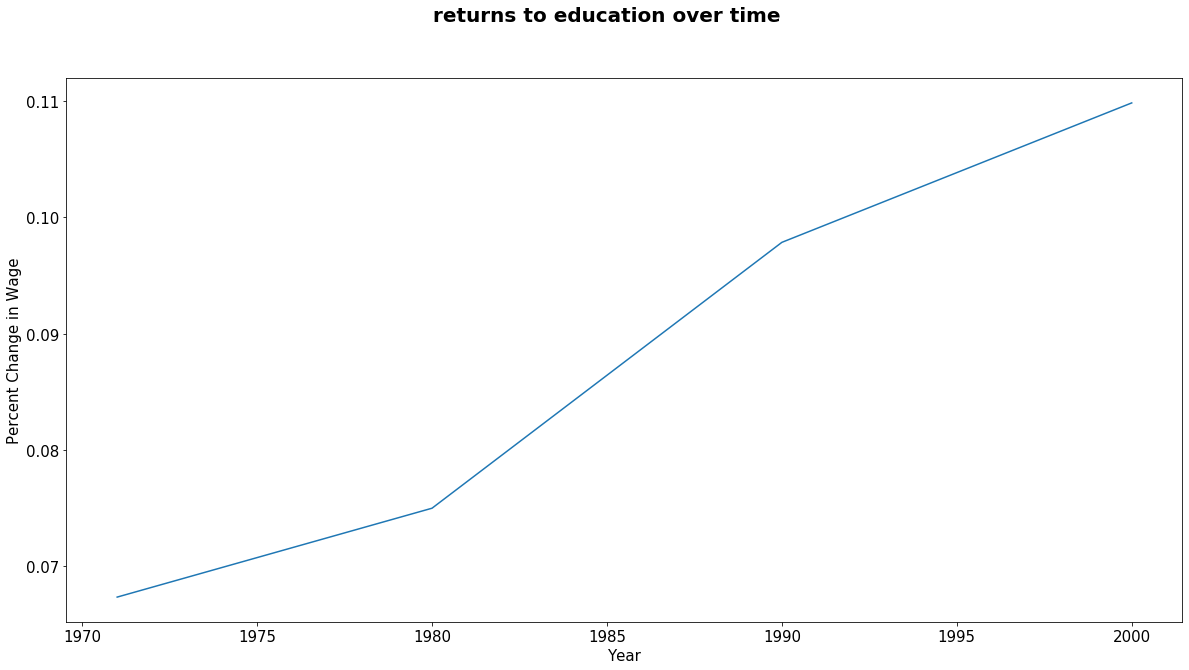

In [93]:
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(20,10))
fig.suptitle('returns to education over time', fontsize=20, fontweight='bold')

plt.plot([1971, 1980, 1990, 2000], [results1971['x'][1], results1980['x'][1], results1990['x'][1], results2000['x'][1]])

plt.ylabel('Percent Change in Wage')
plt.xlabel('Year')

plt.show()


### As expected, the returns to education appear to be increasing